In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")


client = OpenAI(
    api_key=os.getenv("OPENAI_KEY"),
)

MODEL_NAME = "gpt-4o"

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-08-08 16:58:59 __main__ INFO     torch.__version__='2.3.1', torch.version.cuda='12.1'
2024-08-08 16:58:59 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-08-08 16:58:59 __main__ INFO     transformers.__version__='4.43.3'
2024-08-08 16:58:59 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2024-08-08 16:58:59 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'


In [3]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

# model_key = "meta-llama/Meta-Llama-3-8B"
model_key = "meta-llama/Meta-Llama-3-8B-Instruct"
# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "Qwen/Qwen2-7B"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2024-08-08 16:59:00 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]

2024-08-08 16:59:08 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Meta-Llama-3-8B-Instruct> | size: 15316.516 MB | dtype: torch.float16 | device: cuda:0


In [4]:
torch.linspace(0, 1, 11).to(mt.device)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000], device='cuda:0')

In [50]:
from src.utils.typing import TokenizerOutput
from src.functional import get_module_nnsight, untuple, get_hs, PatchSpec
from typing import Literal
from dataclasses import dataclass


#! the clean here actually stands for **corrupt* in the causal tracing
def attribution_patching(
    mt: ModelandTokenizer,
    clean_inputs: TokenizerOutput,
    patches: PatchSpec | list[PatchSpec],
    interested_locations: list[tuple[str, int]],
    ans_token_idx: int,
    metric: Literal["logit", "proba"] = "proba",
    resolution: int = 10,
) -> float:

    if "offset_mapping" in clean_inputs:
        clean_inputs.pop("offset_mapping")
    if isinstance(patches, PatchSpec):
        patches = [patches]

    clean_states = get_hs(
        mt = mt, 
        input = clean_inputs,
        locations = interested_locations,
    )
    patched_states = get_hs(
        mt = mt, 
        input = clean_inputs,
        locations = interested_locations,
        patches = patches
    )

    scan = True

    @dataclass
    class IGCache:
        h: torch.Tensor
        grad: torch.Tensor

        def __post_init__(self):
            self.h.shape == self.grad.shape


    approx_IE = {loc: [] for loc in interested_locations}
    alphas = torch.linspace(0, 1, resolution+1)

    for a_idx in range(len(alphas)-1):
        alpha = alphas[a_idx]

        with mt.trace(clean_inputs, scan=scan) as trace:
            # patching
            for patch in patches:
                module_name, tok_idx = patch.location
                patch_module = get_module_nnsight(mt, module_name)

                assert isinstance(patch.clean, torch.Tensor) and patch.clean.shape == patch.patch.shape
                mid_point = (1 - alpha) * patch.clean + alpha * patch.patch
                mid_point = mid_point.to(mt.device) if not mid_point.device == mt.device else mid_point
                mid_point.retain_grad = True

                patch_module.output[0, tok_idx, :] = mid_point

            # cache the interested hidden states
            for loc in interested_locations:
                module_name, tok_idx = loc
                module = get_module_nnsight(mt, module_name)
                cur_output = (
                    module.output.save()
                    if ("mlp" in module_name or module_name == mt.embedder_name)
                    else module.output[0].save()
                )   #! nnsight quirk => to get the grad of a reference tensor, you can't index it
                
                approx_IE[loc].append(
                    IGCache(
                        h = cur_output[0, tok_idx, :].save(),
                        grad = cur_output.grad[0, tok_idx, :].save()
                    )
                )

            #! nnsight quirk => backward() has to be called later than grad.save() to populate the proxies
            if metric == "logit":
                v = mt.output.logits[0][-1][ans_token_idx]
            elif metric == "proba":
                v = mt.output.logits[0][-1].softmax(dim=-1)[ans_token_idx]
            else:
                raise ValueError(f"unknown {metric=}")
            v.backward()

        mt._model.zero_grad()
        scan = False

    grads = {loc: sum([ig.grad for ig in approx_IE[loc]]) / resolution for loc in interested_locations}

    approx_IE = {
        loc: torch.dot(grad, patched_states[loc] - clean_states[loc]).item() 
        for loc, grad in grads.items()
    } 

    # for loc in interested_locations:
    #     ie_approx = 0
    #     for a_idx in range(len(alphas)-1):
    #         grad = approx_IE[loc][a_idx].grad
    #         h_0 = approx_IE[loc][a_idx].h
    #         h_next = approx_IE[loc][a_idx+1].h if a_idx < len(alphas)-2 else patched_states[loc]

    #         ie_approx += torch.dot(grad, h_next - h_0).item()
        
    #     approx_IE[loc] = ie_approx

    return approx_IE

In [6]:
from src.functional import prepare_input, guess_subject
from src.functional import find_token_range, get_hs
from typing import Optional

def get_h_at_subj(
    mt: ModelandTokenizer,
    layer: str | list[str],
    prompt: str | TokenizerOutput,
    subj: Optional[str] = None,
    input: Optional[TokenizerOutput] = None,
) -> torch.Tensor:
    if subj is None:
        subj = guess_subject(prompt)
        logger.warning(f"no subj provided, guessed {subj=}")
    else:
        assert subj in prompt, f"{subj=} not in {prompt=}"

    skip_prepare_input = input is not None and "offset_mapping" in input
    if not skip_prepare_input:
        logger.debug(f"preparing input for prompt: {prompt}")
        input = prepare_input(
            prompts=prompt, 
            tokenizer=mt, 
            return_offsets_mapping=True
        )
    offset_mapping = input.pop("offset_mapping")[0]
    subj_range = find_token_range(string=prompt, substring=subj, tokenizer=mt.tokenizer, offset_mapping=offset_mapping)
    subj_ends = subj_range[1] - 1

    logger.debug(f"{subj=} => {subj_ends=} | \"{mt.tokenizer.decode(input['input_ids'][0][subj_ends])}\"")

    return get_hs(
        mt = mt, input = input, 
        locations = [(l, subj_ends) for l in layer]
    )


# prompt =  "{} is located in the city of"
# clean_subj = "Louvre"
# patch_subj = "The Space Needle"

# clean_hs, patch_hs = [
#     get_h_at_subj(
#         mt = mt, 
#         layer = [mt.embedder_name],
#         prompt = prompt.format(subj),
#         subj = subj,
#     ) for subj in [clean_subj, patch_subj]
# ]

In [7]:
from src.functional import predict_next_token
from src.trace import insert_padding_before_subj

prompt =  "{} is located in the city of"
clean_subj = "Louvre"
patch_subj = "The Space Needle"

ans = predict_next_token(
    mt = mt,
    inputs = prompt.format(patch_subj),
)[0][0]

logger.debug(ans)

clean_inputs = prepare_input(
    prompts=prompt.format(clean_subj), 
    tokenizer=mt, 
    return_offsets_mapping=True
)
clean_subj_range = find_token_range(
    string=prompt.format(clean_subj), 
    substring=clean_subj, 
    tokenizer=mt.tokenizer,
    offset_mapping=clean_inputs["offset_mapping"][0]
)
logger.debug(f"{clean_subj_range=} | {mt.tokenizer.decode(clean_inputs['input_ids'][0][clean_subj_range[1]-1])}")

patched_inputs = prepare_input(
    prompts=prompt.format(patch_subj), 
    tokenizer=mt, 
    return_offsets_mapping=True
)
patched_subj_range = find_token_range(
    string=prompt.format(patch_subj), 
    substring=patch_subj, 
    tokenizer=mt.tokenizer,
    offset_mapping=patched_inputs["offset_mapping"][0]
)
logger.debug(f"{patched_subj_range=} | {mt.tokenizer.decode(patched_inputs['input_ids'][0][patched_subj_range[1]-1])}")

subj_end = max(clean_subj_range[1], patched_subj_range[1])

clean_inputs = insert_padding_before_subj(
    inp = clean_inputs,
    subj_range = clean_subj_range,
    subj_ends = subj_end,
    pad_id = mt.tokenizer.bos_token_id,
    fill_attn_mask=True
)
patched_inputs = insert_padding_before_subj(
    inp = patched_inputs,
    subj_range = patched_subj_range,
    subj_ends = subj_end,
    pad_id = mt.tokenizer.bos_token_id,
    fill_attn_mask=True
)

clean_subj_shift = subj_end - clean_subj_range[1]
clean_subj_range = (clean_subj_range[0] + clean_subj_shift, subj_end)
patched_subj_shift = subj_end - patched_subj_range[1]
patched_subj_range = (patched_subj_range[0] + patched_subj_shift, subj_end)

subj_start = min(clean_subj_range[0], patched_subj_range[0])

for idx, (tok_id, attn_mask) in enumerate(zip(clean_inputs.input_ids[0], clean_inputs.attention_mask[0])):
    is_subj = clean_subj_range[0] <= idx < clean_subj_range[1]
    append = "*" if is_subj else ""
    print(f"{idx=} [{attn_mask}] | {mt.tokenizer.decode(tok_id)}"+append)

print("-"*50)

for idx, (tok_id, attn_mask) in enumerate(zip(patched_inputs.input_ids[0], patched_inputs.attention_mask[0])):
    is_subj = patched_subj_range[0] <= idx < patched_subj_range[1]
    append = "*" if is_subj else ""
    print(f"{idx=} [{attn_mask}] | {mt.tokenizer.decode(tok_id)}"+append)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


2024-08-08 16:59:13 __main__ DEBUG    " Seattle" (p=0.987)
2024-08-08 16:59:13 __main__ DEBUG    clean_subj_range=(1, 3) | vre
2024-08-08 16:59:13 __main__ DEBUG    patched_subj_range=(1, 4) |  Needle
idx=0 [1] | <|begin_of_text|>
idx=1 [1] | <|begin_of_text|>
idx=2 [1] | Lou*
idx=3 [1] | vre*
idx=4 [1] |  is
idx=5 [1] |  located
idx=6 [1] |  in
idx=7 [1] |  the
idx=8 [1] |  city
idx=9 [1] |  of
--------------------------------------------------
idx=0 [1] | <|begin_of_text|>
idx=1 [1] | The*
idx=2 [1] |  Space*
idx=3 [1] |  Needle*
idx=4 [1] |  is
idx=5 [1] |  located
idx=6 [1] |  in
idx=7 [1] |  the
idx=8 [1] |  city
idx=9 [1] |  of


In [8]:
emb_clean = get_hs(
    mt = mt, 
    input = clean_inputs,
    locations = [(mt.embedder_name, tok_idx) for tok_idx in range(subj_start, subj_end)]
)
emb_patch = get_hs(
    mt = mt, 
    input = patched_inputs,
    locations = [(mt.embedder_name, tok_idx) for tok_idx in range(subj_start, subj_end)]
)

for key in emb_clean.keys():
    print(f"{key=} | {emb_clean[key].shape=} | {emb_patch[key].shape=}")

key=('model.embed_tokens', 1) | emb_clean[key].shape=torch.Size([4096]) | emb_patch[key].shape=torch.Size([4096])
key=('model.embed_tokens', 2) | emb_clean[key].shape=torch.Size([4096]) | emb_patch[key].shape=torch.Size([4096])
key=('model.embed_tokens', 3) | emb_clean[key].shape=torch.Size([4096]) | emb_patch[key].shape=torch.Size([4096])


In [9]:
patch_spec = [
    PatchSpec(
        location = location,
        patch = emb_patch[location],
        clean = emb_clean[location],
    ) for location in emb_clean.keys()
]

test_h = get_hs(
    mt=mt,
    input=clean_inputs,
    locations=[(mt.embedder_name, subj_end - 1)],
    # patches=PatchSpec(
    #     location=(mt.embedder_name, subj_end - 1),
    #     patch=emb_patch[(mt.embedder_name, subj_end - 1)],  
    # ),
    patches=patch_spec,
)

torch.allclose(emb_patch[(mt.embedder_name, subj_end - 1)], test_h)

True

In [10]:
clean_predictions = predict_next_token(mt = mt, inputs = clean_inputs)
clean_predictions

[[PredictedToken(token=' Paris', prob=0.5268027186393738, token_id=tensor(12366, device='cuda:0')),
  PredictedToken(token=' Lou', prob=0.030424969270825386, token_id=tensor(9928, device='cuda:0')),
  PredictedToken(token=' Abu', prob=0.02351059392094612, token_id=tensor(31229, device='cuda:0')),
  PredictedToken(token=' Athens', prob=0.009425216354429722, token_id=tensor(46926, device='cuda:0')),
  PredictedToken(token=' the', prob=0.008125044405460358, token_id=tensor(279, device='cuda:0'))]]

In [11]:
patch_predictions = predict_next_token(mt = mt, inputs = patched_inputs)
patch_predictions

[[PredictedToken(token=' Seattle', prob=0.9870282411575317, token_id=tensor(16759, device='cuda:0')),
  PredictedToken(token=' Bell', prob=0.0012792334891855717, token_id=tensor(18366, device='cuda:0')),
  PredictedToken(token=' Seat', prob=0.0009286241256631911, token_id=tensor(40323, device='cuda:0')),
  PredictedToken(token=' Bellev', prob=0.0008860992384143174, token_id=tensor(86705, device='cuda:0')),
  PredictedToken(token=' Frem', prob=0.0005676564760506153, token_id=tensor(68310, device='cuda:0'))]]

In [12]:
# locations = [(mt.embedder_name, tok_idx) for tok_idx in range(clean_inputs.input_ids.shape[1])]
locations = []
for l_idx in range(mt.n_layer):
    module = mt.layer_name_format.format(l_idx)
    for tok_idx in range(clean_inputs.input_ids.shape[1]):
        locations.append((module, tok_idx))

In [13]:
# from src.functional import logit_lens
# hs = get_hs(
#     mt = mt, 
#     input = patched_inputs,
#     locations = locations,
# )
# logit_lens(mt=mt, h=hs[(mt.layer_names[-1], clean_inputs.input_ids.shape[1] - 1)], get_proba=True)

In [14]:
# from src.functional import logit_lens
# hs_str = get_hs(
#     mt = mt, 
#     input = clean_inputs,
#     locations = locations,
#     patches=patch_spec,
# )
# # hs_str[(mt.layer_names[-1], clean_inputs.input_ids.shape[1] - 1)]
# logit_lens(mt=mt, h=hs_str[(mt.layer_names[-1], clean_inputs.input_ids.shape[1] - 1)], get_proba=True)

In [15]:
# # layer = mt.embedder_name
# layer = mt.layer_names[0]
# for tok_idx in range(clean_inputs.input_ids.shape[1]):
#     h = hs[(layer, tok_idx)]
#     h_str = hs_str[(layer, tok_idx)]
#     print(f"{tok_idx=} | {mt.tokenizer.decode(patched_inputs.input_ids[0][tok_idx])} => {h.norm().item()=} | {h_str.norm().item()=} || {torch.allclose(h, h_str)}")

In [16]:
clean_inputs.input_ids.shape, patched_inputs.input_ids.shape

(torch.Size([1, 10]), torch.Size([1, 10]))

In [51]:
results = attribution_patching(
    mt = mt,
    clean_inputs = clean_inputs,
    patches = patch_spec,
    interested_locations=locations,
    ans_token_idx=ans.token_id,
)

In [52]:
trace_start_idx = 1
approx_effects = torch.zeros(
    len(range(trace_start_idx, clean_inputs.input_ids.shape[1])), 
    mt.n_layer
)
for l in range(mt.n_layer):
    for t in range(trace_start_idx, clean_inputs.input_ids.shape[1]):
        approx_effects[t - trace_start_idx, l] = results[(mt.layer_name_format.format(l), t)]
approx_effects.shape

torch.Size([9, 32])

2024-08-08 18:51:55 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f47fe887a90>
2024-08-08 18:51:55 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-08 18:51:55 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-08 18:51:55 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-08 18:51:55 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


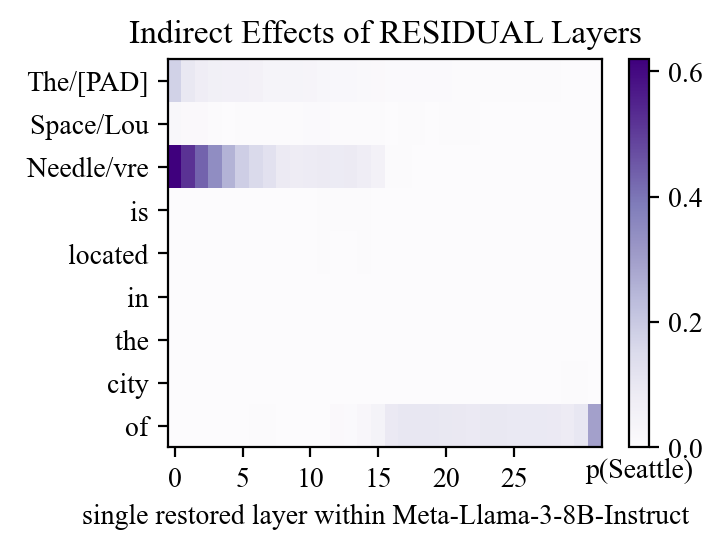

In [53]:
from src.trace import CausalTracingResult
from src.plotting import plot_trace_heatmap

trace_result = CausalTracingResult(
    corrupt_input_toks = [mt.tokenizer.decode(tok) for tok in clean_inputs.input_ids[0]],
    clean_input_toks = [mt.tokenizer.decode(tok) for tok in patched_inputs.input_ids[0]],
    trace_start_idx=1,
    answer = ans,
    low_score = 0.0,
    window = 1,
    normalized = False,
    kind="residual",
    indirect_effects=approx_effects,
)

plot_trace_heatmap(
    result = trace_result,
    model_name = mt.name.split("/")[-1],
)

In [43]:
prompt, clean_subj, patch_subj

('{} is located in the city of', 'Louvre', 'The Space Needle')

In [48]:
from src.trace import trace_important_states

indirect_effects = trace_important_states(
    mt = mt, 
    prompt_template = prompt,
    clean_subj = clean_subj,
    patched_subj = patch_subj,
    kind="residual",
    window_size=1,
    normalize=False
)

2024-08-08 18:12:08 src.trace DEBUG    answer=PredictedToken(token=' Seattle', prob=0.9870282411575317, token_id=tensor(16759, device='cuda:0'))
2024-08-08 18:12:09 src.trace DEBUG    clean_answer=PredictedToken(token=' Paris', prob=0.7363205552101135, token_id=tensor(12366, device='cuda:0'))
2024-08-08 18:12:09 src.trace DEBUG    track_ans=[(155, PredictedToken(token=' Seattle', prob=0.00017379186465404928, token_id=16759))]
2024-08-08 18:12:09 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 320/320 [00:10<00:00, 31.42it/s]


2024-08-08 18:12:47 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f47ffd45c90>
2024-08-08 18:12:47 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-08 18:12:47 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-08 18:12:47 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-08 18:12:47 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


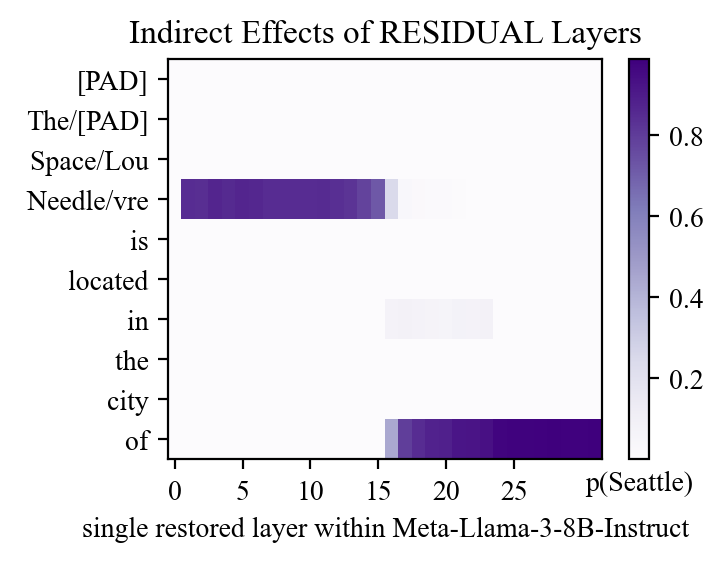

In [49]:
plot_trace_heatmap(
    result = indirect_effects,
    model_name = mt.name.split("/")[-1],
)

In [224]:
from src.functional import untuple

clean_inputs = prepare_input(
    prompts=prompt.format(clean_subj), 
    tokenizer=mt, 
    return_offsets_mapping=False
)


cur_grads = {l: None for l in mt.layer_names}

# module_name = mt.layer_name_format.format(10)
# module_name = mt.embedder_name
module_name = mt.mlp_module_name_format.format(10)
# module_name = mt.attn_module_name_format.format(10)

# h = torch.zeros(mt.n_embd).to(mt.device)
# h = []

h = torch.Tensor([0.0]).to(mt.device)

def add(t):
    h += t

with mt.trace(clean_inputs, scan = True) as trace:
    module = get_module_nnsight(mt, module_name)
    mid_point = module.output.save()

    # # h_grad = module.output.grad[0, 5, :].save()
    # h_grad = mid_point.grad[0, 5, :].save()
    # h_mid = mid_point[0, 5, :].save()
    # h.append((mid_point[0, 5, :] + mid_point[0, 6, :]).norm().save())
    trace.apply(print, mid_point[0, 5, :].norm()) 
    h = mid_point[0, 5, :].norm().save()

    # m = mt.output.logits[0][-1].softmax(dim=-1)[ans.token_id]
    # m.backward()



    # for l in cur_grads:
    #     module = get_module_nnsight(mt, l)
    #     cur_grads[l] = module.output[0].grad.save()

tensor(2.5547, device='cuda:0', dtype=torch.float16,
       grad_fn=<LinalgVectorNormBackward0>)


In [225]:
# for module, grad in cur_grads.items():
#     print(module, grad.shape)
h

tensor(2.5547, device='cuda:0', dtype=torch.float16,
       grad_fn=<LinalgVectorNormBackward0>)

In [203]:
untuple(mid_point).shape

torch.Size([1, 9, 4096])

In [13]:
type(mid_point[-1])

torch.Tensor

In [14]:
mt.layer_names

['model.layers.0',
 'model.layers.1',
 'model.layers.2',
 'model.layers.3',
 'model.layers.4',
 'model.layers.5',
 'model.layers.6',
 'model.layers.7',
 'model.layers.8',
 'model.layers.9',
 'model.layers.10',
 'model.layers.11',
 'model.layers.12',
 'model.layers.13',
 'model.layers.14',
 'model.layers.15',
 'model.layers.16',
 'model.layers.17',
 'model.layers.18',
 'model.layers.19',
 'model.layers.20',
 'model.layers.21',
 'model.layers.22',
 'model.layers.23',
 'model.layers.24',
 'model.layers.25',
 'model.layers.26',
 'model.layers.27',
 'model.layers.28',
 'model.layers.29',
 'model.layers.30',
 'model.layers.31']

In [205]:
import nnsight
nnsight.__version__

AttributeError: module 'nnsight' has no attribute '__version__'